# Switch de modèle avec trafic aérien

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [4]:
#importe les données transformées du trafic aérien
df_air_trafic = pd.read_csv("df_air_trafic_corrigee.csv", index_col=0)
df_air_trafic['sheduled_time_start'] = pd.to_datetime(df_air_trafic['sheduled_time_start'])
df_air_trafic

,country_origin,citydest,sheduled_time_start,seats,number_planes,Year,Month,Day,Year-Month
64488,Hungary,Paris,2017-05-16,462.0,3,2017,5,16,2017-05
64345,Germany,Basel,2017-05-16,592.0,5,2017,5,16,2017-05
64346,France,Toulon,2017-05-16,334.0,3,2017,5,16,2017-05
64347,France,Bordeaux,2017-05-16,1736.0,15,2017,5,16,2017-05
64348,Portugal,Toulouse,2017-05-16,437.0,3,2017,5,16,2017-05
...,...,...,...,...,...,...,...,...,...
265668,Germany,Paris,2021-12-07,1314.0,9,2021,12,7,2021-12
265666,Portugal,Paris,2021-12-07,183.0,2,2021,12,7,2021-12
265684,France,Nice,2021-12-07,1387.0,9,2021,12,7,2021-12
265672,Tunisia,Paris,2021-12-07,298.0,2,2021,12,7,2021-12


In [6]:
df_air_trafic2 = df_air_trafic.drop(['number_planes', "Year", "Month", "Day", "Year-Month", "country_origin"], axis=1)
df_air_trafic2

,citydest,sheduled_time_start,seats
64488,Paris,2017-05-16,462.0
64345,Basel,2017-05-16,592.0
64346,Toulon,2017-05-16,334.0
64347,Bordeaux,2017-05-16,1736.0
64348,Toulouse,2017-05-16,437.0
...,...,...,...
265668,Paris,2021-12-07,1314.0
265666,Paris,2021-12-07,183.0
265684,Nice,2021-12-07,1387.0
265672,Paris,2021-12-07,298.0


In [8]:
#liste des destinations
df_air_trafic2["citydest"].unique()

array(['Paris', 'Basel', 'Toulon', 'Bordeaux', 'Toulouse', 'Nice',
       'Marseille', 'Lyon', 'Nantes', 'Rennes', 'Strasbourg',
       'Carcassonne', 'Montpellier', 'Beziers', 'Caen', 'Figari',
       'Biarritz', 'Perpignan', 'Tarbes', 'Ajaccio', 'Bastia', 'Rodez',
       'Metz-Nancy', 'Brive', 'Calvi', 'Dinard', 'Clermont-Ferrand',
       'Brest', 'Nimes', 'Limoges', 'Castres', 'Lorient', 'Lille',
       'Poitiers', 'Quimper', 'Bergerac', 'Grenoble', 'Pau',
       'La Rochelle', 'Tours', 'Dole', 'Agen', 'Deauville', 'Cannes',
       'Chateauroux', 'Saint Nazaire', 'Chambery', 'Mulhouse',
       'Perigueux', 'Angers', 'Toussus-Le-Noble', 'St Brieuc', 'Orleans',
       'Aurillac', 'Dijon', 'Calais', 'Auxerre'], dtype=object)

In [15]:
def variation_seats(ville):
    
    df_air_trafic_ville = df_air_trafic2[df_air_trafic2["citydest"] == ville]
    df_air_trafic_ville = df_air_trafic_ville.groupby('sheduled_time_start').agg({'seats': "sum"})
    
    df_air_trafic_ville["variation_sieges_niveau"] = df_air_trafic_ville["seats"].diff()
    df_air_trafic_ville["variation_sieges_pourcentage"] = df_air_trafic_ville["seats"].pct_change()

    return(df_air_trafic_ville)

In [17]:
df_paris = variation_seats("Paris")
df_paris

,seats,variation_sieges_niveau,variation_sieges_pourcentage
sheduled_time_start,,,
2017-05-16,79018.0,NaN,NaN
2017-05-17,88615.0,9597.0,0.121453
2017-05-18,89252.0,637.0,0.007188
2017-05-19,69332.0,-19920.0,-0.223188
2017-05-20,84615.0,15283.0,0.220432
...,...,...,...
2021-12-03,45374.0,1734.0,0.039734
2021-12-04,42868.0,-2506.0,-0.055230
2021-12-05,45895.0,3027.0,0.070612


<AxesSubplot:xlabel='sheduled_time_start'>

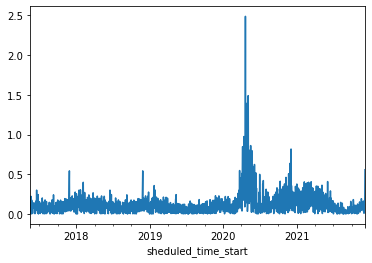

In [23]:
df_paris["variation_sieges_pourcentage"].abs().plot()

In [24]:
df_paris["variation_sieges_pourcentage"].abs().describe()

count    1666.000000
mean        0.117924
std         0.137948
min         0.000000
25%         0.036822
50%         0.084096
75%         0.149785
max         2.487979
Name: variation_sieges_pourcentage, dtype: float64